# About this kernel

A fork of the very comprehensive [starter kernel](https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu). I didn't add much, remove a whole bunch (please check out the official kernel for more info), hide some big scary functions. I mostly just hooked the largest efficientnet laying around and ran it for a couple 'pochs. Please consume this with moderation (only 30h per week!).



## Updates

* V9: Tried warmup by only training softmax layer for 5 epochs before unfreezing all weights.
* V10: More data augmentations
* V11: Use LR Scheduler, idea comes from here.
* V12: Use both training and validation data to train model.
* V14: Train longer (25 epochs).
* V15: Back to 20 epochs; Global Max Pooling instead of Average.
* V16: Roll back to Global Average Pooling
* V18: Roll back to V13

* V19: Added DenseNet201 and MobileNetV2---> 0.96127 Ifeel like DenseNet201 overfitted on the data because epoch 18, 19, 20 had acc = 1.0000 
* V20: Added InceptionV3
* V21: Added Xception---> 0.96228


In [1]:
!pip install -q efficientnet

In [2]:
import math, re, os
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
import efficientnet.tfkeras as efn
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception
import tensorflow.keras.backend as K
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.1.0


# Configurations

In [3]:
AUTO = tf.data.experimental.AUTOTUNE

# Create strategy from tpu
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

# Configuration
IMAGE_SIZE = [512, 512]
EPOCHS = 20
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
print(BATCH_SIZE)

128


In [4]:
GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition

Unhide to see `CLASSES`:

In [5]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

# Helper Functions
## Visualization

In [6]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

## Datasets Functions

In [7]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label, seed=2020):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image, seed=seed)
#     image = tf.image.random_flip_up_down(image, seed=seed)
#     image = tf.image.random_brightness(image, 0.1, seed=seed)
    
#     image = tf.image.random_jpeg_quality(image, 85, 100, seed=seed)
#     image = tf.image.resize(image, [530, 530])
#     image = tf.image.random_crop(image, [512, 512], seed=seed)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset(do_aug = True):
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True, ordered = False)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    if do_aug: dataset = dataset.map(transform, num_parallel_calls=AUTO)
    #dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset():
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_train_valid_datasets():
    dataset = load_dataset(TRAINING_FILENAMES + VALIDATION_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    #if do_aug: dataset = dataset.map(transform, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=True)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [8]:
import math
#AUGMENTATIONS OF IMAGES!
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

In [9]:
def transform(image,label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]),label

In [10]:
row = 3; col = 4;
all_elements = get_training_dataset(load_dataset(TRAINING_FILENAMES),do_aug=False).unbatch()
one_element = tf.data.Dataset.from_tensors( next(iter(all_elements)) )
augmented_element = one_element.repeat().map(transform).batch(row*col)

for (img,label) in augmented_element:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

TypeError: get_training_dataset() got multiple values for argument 'do_aug'

## Model Functions

In [11]:
def lrfn(epoch):
    LR_START = 0.00001
    LR_MAX = 0.00005 * strategy.num_replicas_in_sync
    LR_MIN = 0.00001
    LR_RAMPUP_EPOCHS = 5
    LR_SUSTAIN_EPOCHS = 0
    LR_EXP_DECAY = .8
    
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

In [12]:

def unfreeze(model):
    for layer in model.layers:
        layer.trainable = True
        

def unfreeze(model2):
    for layer in model.layers:
        layer.trainable = True


def unfreeze(model3):
    for layer in model.layers:
        layer.trainable = True
        


def unfreeze(model4):
    for layer in model.layers:
        layer.trainable = True
        

def unfreeze(model5):
    for layer in model.layers:
        layer.trainable = True

# Training Model

In [13]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


## Load Model into TPU

In [14]:
# Need this line so Google will recite some incantations
# for Turing to magically load the model onto the TPU

with strategy.scope():
    enet = efn.EfficientNetB7(
        input_shape=(512, 512, 3),
        weights='noisy-student',
        include_top=False
    )
    
    model = tf.keras.Sequential([
        enet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
        
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    model.summary()

258072576/258068648 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 16, 16, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               266344    
Total params: 64,364,024
Trainable params: 64,053,304
Non-trainable params: 310,720
_________________________________________________________________


In [15]:
with strategy.scope():
    rnet = DenseNet201(
        input_shape=(512, 512, 3),
        weights='imagenet',
        include_top=False
    )

    model2 = tf.keras.Sequential([
        rnet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
        
model2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model2.summary()




74842112/74836368 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 16, 16, 1920)      18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 104)               199784    
Total params: 18,521,768
Trainable params: 18,292,712
Non-trainable params: 229,056
_________________________________________________________________


In [16]:
with strategy.scope():
    mnet = MobileNetV2(
        input_shape=(512, 512, 3),
        weights='imagenet',
        include_top=False
    )

    model3 = tf.keras.Sequential([
        mnet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
        
model3.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model3.summary()


/opt/conda/lib/python3.6/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 16, 16, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 104)               133224    
Total params: 2,391,208
Trainable params: 2,357,096
Non-trainable params: 34,112
_________________________________________________________________


In [17]:
with strategy.scope():
    InV3 = InceptionV3(
        input_shape=(512, 512, 3),
        weights='imagenet',
        include_top=False
    )

    model4 = tf.keras.Sequential([
        InV3,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
        
model4.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model4.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 14, 14, 2048)      21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 104)               213096    
Total params: 22,015,880
Trainable params: 21,981,448
Non-trainable params: 34,432
_________________________________________________________________


In [18]:
with strategy.scope():
    Xce = Xception(
        input_shape=(512, 512, 3),
        weights='imagenet',
        include_top=False
    )

    model5 = tf.keras.Sequential([
        Xce,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
        
model5.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model5.summary()

83689472/83683744 [==============================] - 14s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 16, 16, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 104)               213096    
Total params: 21,074,576
Trainable params: 21,020,048
Non-trainable params: 54,528
_________________________________________________________________


## Training

In [19]:
import pandas as pd

In [20]:
# scheduler = tf.keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

history1 = model.fit(
    get_training_dataset(), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS, 
    validation_data= get_validation_dataset(),
    callbacks=[lr_schedule]
)


Train for 99 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/20
99/99 [==============================] - 427s 4s/step - loss: 4.5978 - sparse_categorical_accuracy: 0.0458 - val_loss: 4.5751 - val_sparse_categorical_accuracy: 0.0854

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/20
99/99 [==============================] - 110s 1s/step - loss: 3.4261 - sparse_categorical_accuracy: 0.2955 - val_loss: 2.2789 - val_sparse_categorical_accuracy: 0.5183

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/20
99/99 [==============================] - 102s 1s/step - loss: 1.3853 - sparse_categorical_accuracy: 0.6860 - val_loss: 0.6197 - val_sparse_categorical_accuracy: 0.8615

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/20
99/99 [==============================] - 107s 1s/step - loss: 0.6336 - sparse_categorical_accuracy: 0.8430 - val_loss: 0.3198 - val_sparse_categorica

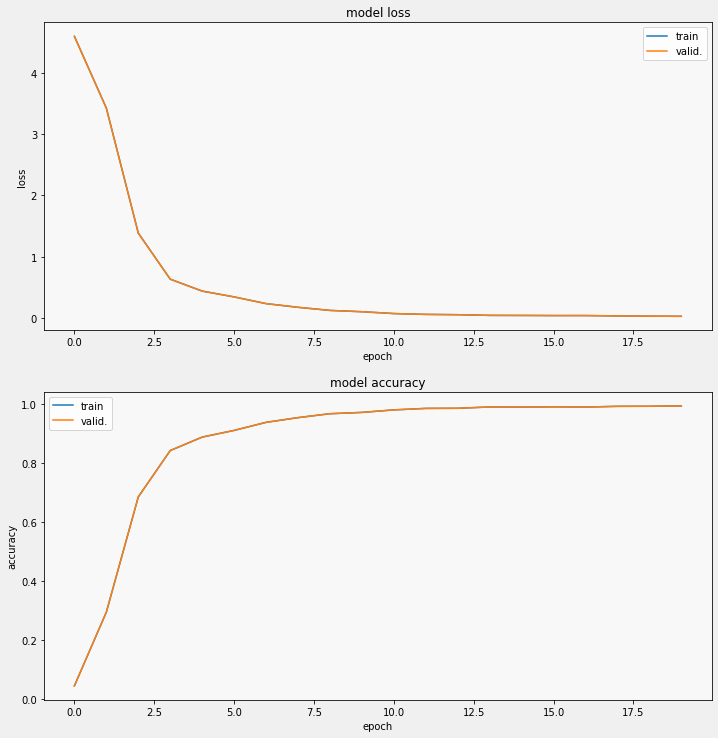

In [21]:
display_training_curves(history1.history['loss'], history1.history['loss'], 'loss', 211)
display_training_curves(history1.history['sparse_categorical_accuracy'], history1.history['sparse_categorical_accuracy'], 'accuracy', 212)


In [22]:
history2 = model2.fit(
    get_training_dataset(),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS, 
    validation_data= get_validation_dataset(),
    callbacks=[lr_schedule]
)


Train for 99 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/20
99/99 [==============================] - 439s 4s/step - loss: 4.2892 - sparse_categorical_accuracy: 0.1061 - val_loss: 3.9386 - val_sparse_categorical_accuracy: 0.1487

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/20
99/99 [==============================] - 79s 793ms/step - loss: 1.9381 - sparse_categorical_accuracy: 0.6029 - val_loss: 1.0940 - val_sparse_categorical_accuracy: 0.7069

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/20
99/99 [==============================] - 73s 735ms/step - loss: 0.8126 - sparse_categorical_accuracy: 0.8314 - val_loss: 0.5352 - val_sparse_categorical_accuracy: 0.8319

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/20
99/99 [==============================] - 71s 716ms/step - loss: 0.4851 - sparse_categorical_accuracy: 0.8990 - val_loss: 0.5377 - val_sparse_cate

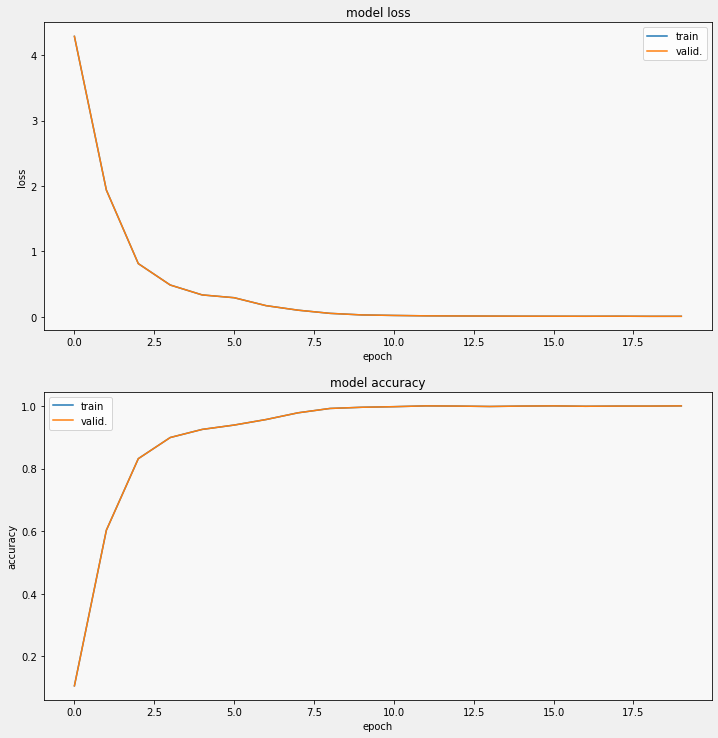

In [23]:
display_training_curves(history2.history['loss'], history2.history['loss'], 'loss', 211)
display_training_curves(history2.history['sparse_categorical_accuracy'], history2.history['sparse_categorical_accuracy'], 'accuracy', 212)


In [24]:
history3= model3.fit(
    get_training_dataset(),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS, 
    validation_data= get_validation_dataset(),
    callbacks=[lr_schedule]
)

Train for 99 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/20
99/99 [==============================] - 98s 995ms/step - loss: 4.5232 - sparse_categorical_accuracy: 0.0442 - val_loss: 4.5402 - val_sparse_categorical_accuracy: 0.0216

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/20
99/99 [==============================] - 26s 265ms/step - loss: 2.8708 - sparse_categorical_accuracy: 0.3649 - val_loss: 2.9400 - val_sparse_categorical_accuracy: 0.2866

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/20
99/99 [==============================] - 25s 254ms/step - loss: 1.3728 - sparse_categorical_accuracy: 0.6799 - val_loss: 2.4629 - val_sparse_categorical_accuracy: 0.3944

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/20
99/99 [==============================] - 28s 283ms/step - loss: 0.8145 - sparse_categorical_accuracy: 0.8037 - val_loss: 2.7269 - val_sparse_ca

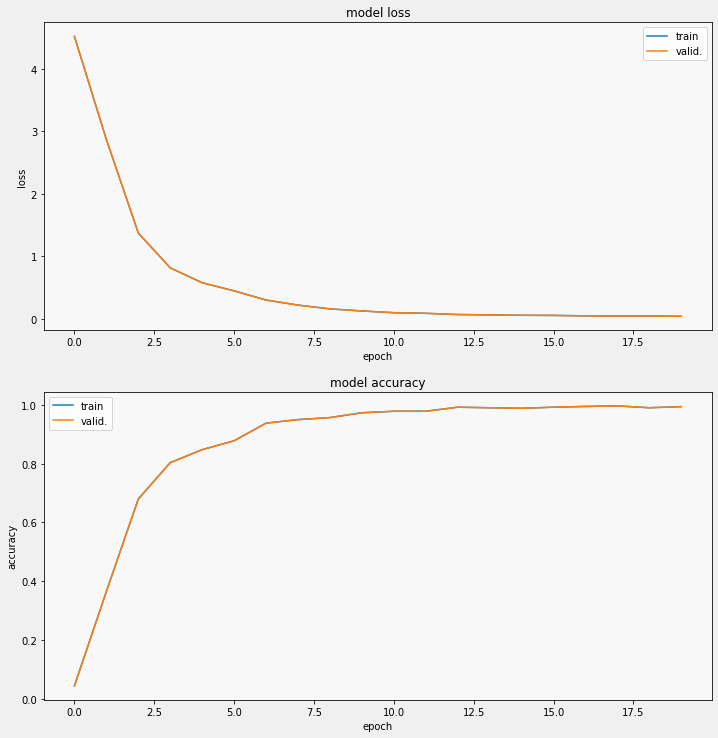

In [25]:
display_training_curves(history3.history['loss'], history3.history['loss'], 'loss', 211)
display_training_curves(history3.history['sparse_categorical_accuracy'], history3.history['sparse_categorical_accuracy'], 'accuracy', 212)


In [26]:
history4= model4.fit(
    get_training_dataset(),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS, 
    validation_data= get_validation_dataset(),
    callbacks=[lr_schedule]
)


Train for 99 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/20
99/99 [==============================] - 146s 1s/step - loss: 4.2462 - sparse_categorical_accuracy: 0.1225 - val_loss: 3.6875 - val_sparse_categorical_accuracy: 0.2177

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/20
99/99 [==============================] - 32s 319ms/step - loss: 2.0144 - sparse_categorical_accuracy: 0.5568 - val_loss: 0.8868 - val_sparse_categorical_accuracy: 0.7629

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/20
99/99 [==============================] - 32s 322ms/step - loss: 0.7757 - sparse_categorical_accuracy: 0.8213 - val_loss: 0.4715 - val_sparse_categorical_accuracy: 0.8836

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/20
99/99 [==============================] - 34s 342ms/step - loss: 0.4678 - sparse_categorical_accuracy: 0.8838 - val_loss: 0.5711 - val_sparse_cate

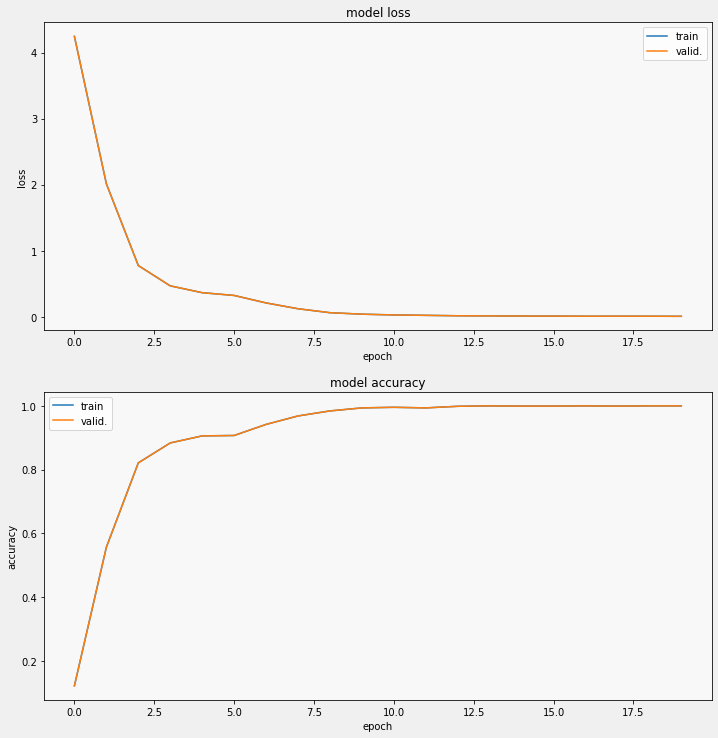

In [27]:
display_training_curves(history4.history['loss'], history4.history['loss'], 'loss', 211)
display_training_curves(history4.history['sparse_categorical_accuracy'], history4.history['sparse_categorical_accuracy'], 'accuracy', 212)


In [28]:
history5= model5.fit(
    get_training_dataset(),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS, 
    validation_data= get_validation_dataset(),
    callbacks=[lr_schedule]
)

Train for 99 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/20
99/99 [==============================] - 117s 1s/step - loss: 4.4660 - sparse_categorical_accuracy: 0.0934 - val_loss: 4.1697 - val_sparse_categorical_accuracy: 0.2004

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/20
99/99 [==============================] - 31s 313ms/step - loss: 2.6484 - sparse_categorical_accuracy: 0.4520 - val_loss: 1.4331 - val_sparse_categorical_accuracy: 0.6659

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/20
99/99 [==============================] - 34s 345ms/step - loss: 1.0396 - sparse_categorical_accuracy: 0.7885 - val_loss: 0.5532 - val_sparse_categorical_accuracy: 0.8815

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/20
99/99 [==============================] - 31s 317ms/step - loss: 0.4843 - sparse_categorical_accuracy: 0.9015 - val_loss: 0.4384 - val_sparse_cate

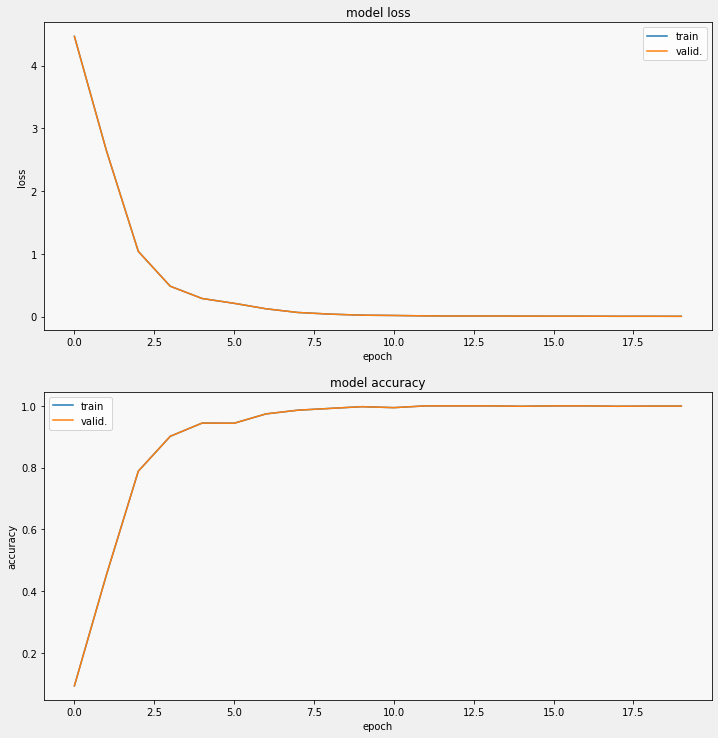

In [29]:
display_training_curves(history5.history['loss'], history5.history['loss'], 'loss', 211)
display_training_curves(history5.history['sparse_categorical_accuracy'], history5.history['sparse_categorical_accuracy'], 'accuracy', 212)


# Predictions model1 {ENet+DenseNet201+MobileNetv2+InceptionV3+Xception}

In [30]:
test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
#ENet
probabilities1 = model.predict(test_images_ds)
#DenseNet201
probabilities2 = model2.predict(test_images_ds)
#MobileNetV2
probabilities3 = model3.predict(test_images_ds)
#InceptionV3
probabilities4 = model4.predict(test_images_ds)
#Xception
probabilities5 = model5.predict(test_images_ds)
#average

probabilities = (probabilities1 + probabilities2+ probabilities3+ probabilities4 +  probabilities5)/5
#predictions1 = np.argmax(probabilities1, axis=-1)
#predictions2 = np.argmax(probabilities2, axis=-1)
#predictions3 = np.argmax(probabilities3, axis=-1)
#predictions4 = np.argmax(probabilities4, axis=-1)
#predictions5 = np.argmax(probabilities5, axis=-1)
#print(predictions1)
#print(predictions2)
#print(predictions3)
#print(predictions4)
#print(predictions5)
predictions = np.argmax(probabilities, axis=-1)
print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
#np.savetxt('submissionD.csv', np.rec.fromarrays([test_ids, predictions2]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
#np.savetxt('submissionM.csv', np.rec.fromarrays([test_ids, predictions3]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
#np.savetxt('submissionI.csv', np.rec.fromarrays([test_ids, predictions4]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
#np.savetxt('submissionX.csv', np.rec.fromarrays([test_ids, predictions5]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')


Computing predictions...
Generating submission.csv file...
